<a href="https://colab.research.google.com/github/skang0812/undergrad_ml_assignments/blob/main/01_assignment_wrangling_and_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Wrangling and EDA
### Foundations of Machine Learning

In [87]:
! git clone https://github.com/ds4e/scratchpad
%run ./scratchpad/get_data.py

fatal: destination path 'scratchpad' already exists and is not an empty directory.


<Figure size 640x480 with 0 Axes>

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `airbnb_NYC.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? For the remaining missing values, replace the `np.nan/None` values with the label `Missing`.
3. Dummy variable: For `metabric.csv`, convert the `Overall Survival Status` variable into a dummy/binary variable, taking the value 0 if the patient is deceased and 1 if they are living.
4. Missing values: For `airbnb_NYC.csv`, determine how many missing values of `Review Scores Rating` there are. Create a new variable, in which you impute the median score for non-missing observations to the missing ones. Why might this bias or otherwise negatively impact your results?

Q1 Response

(1) To clean the Price variable, I first had to load the dataset using encoding='latin1' because the default UTF-8 wouldn't read some of the special characters in the file. The main issue with the Price column was that it was stored as a string with dollar signs and commas, which makes it impossible to do any math on. I used .str.replace() to strip those out, which is super important because prices like $1,112 have that extra comma that breaks standard float conversion. After that, I converted the whole column to a float type. When I checked for missing values after the cleaning was done, I ended up with 0 missing values.

In [88]:
import pandas as pd
import numpy as np

df_airbnb = pd.read_csv('data/airbnb_NYC.csv', encoding='latin1')

df_airbnb['price_cleaned'] = (df_airbnb['Price']
                              .str.replace('$', '', regex=False)
                              .str.replace(',', '', regex=False)
                              .astype(float))

missing_count = df_airbnb['price_cleaned'].isna().sum()

print(f"Number of missing values after cleaning: {missing_count}")
print(df_airbnb[['Price', 'price_cleaned']].head())

Number of missing values after cleaning: 0
  Price  price_cleaned
0   145          145.0
1    37           37.0
2    28           28.0
3   199          199.0
4   549          549.0


(2) I found that 76.19% of the subject_injury data is missing. After cross-tabulating with force_type, a clear pattern emerged: data is most frequently missing in cases involving "Bodily Force" (7,051 missing) and "Chemical Irritant" (1,421 missing). This suggests injuries might be documented less consistently during these specific types of police encounters. To clean the variable for further analysis, I replaced all remaining NaN values with the label "Missing".

In [89]:
df_police = pd.read_csv('data/mn_police_use_of_force.csv')

prop_missing = df_police['subject_injury'].isna().mean()
print(f"Proportion of missing values: {prop_missing:.2%}")

ct = pd.crosstab(df_police['subject_injury'].fillna('Missing'), df_police['force_type'])
print("\nCross-tabulation Table:")
print(ct)

df_police['subject_injury'] = df_police['subject_injury'].fillna('Missing')

Proportion of missing values: 76.19%

Cross-tabulation Table:
force_type      Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury                                                    
Missing             2          7051               1421        0   
No                  0          1093                131        2   
Yes                 2          1286                 41        0   

force_type      Gun Point Display  Improvised Weapon  Less Lethal  \
subject_injury                                                      
Missing                        27                 74           87   
No                             33                 34            0   
Yes                            44                 40            0   

force_type      Less Lethal Projectile  Maximal Restraint Technique  \
subject_injury                                                        
Missing                              0                          170   
No                                   1     

(3)

In [90]:
df_metabric = pd.read_csv('data/metabric.csv')

df_metabric['survival_dummy'] = df_metabric['Overall Survival Status'].map({'LIVING': 1, 'DECEASED': 0})

print(df_metabric[['Overall Survival Status', 'survival_dummy']].head())

  Overall Survival Status  survival_dummy
0                0:LIVING             NaN
1              1:DECEASED             NaN
2                0:LIVING             NaN
3              1:DECEASED             NaN
4              1:DECEASED             NaN


(4) Using median imputation for the Review Scores Rating variable might've negatively impacted my results because it can lead to biased estimates. Even though it helped me handle the 8,323 missing values I found, it artificially reduces the variance in the dataset. By filling every gap with the exact same median value, the distribution becomes much more peaked than it should be, which could hide actual differences between listings and potentially make the model less accurate.

In [91]:
missing_reviews = df_airbnb['Review Scores Rating'].isna().sum()
print(f"Missing values for Review Scores Rating: {missing_reviews}")

review_median = df_airbnb['Review Scores Rating'].median()

df_airbnb['Review_Scores_Imputed'] = df_airbnb['Review Scores Rating'].fillna(review_median)

print(f"Missing values in new column: {df_airbnb['Review_Scores_Imputed'].isna().sum()}")

Missing values for Review Scores Rating: 8323
Missing values in new column: 0


**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work. What does work?
2. Drop any columns that do not contain data.
3. What is an observation? Carefully justify your answer, and explain how it affects your choices in cleaning and analyzing the data.
4. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
5. Clean the Age variable and make a histogram of the ages of the victims.
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Thoughts?

Q2 Response

(1) I used pd.read_excel() to open the file because the global shark attack data is provided as an Excel spreadsheet rather than a standard CSV.

(2)

In [92]:
import pandas as pd

df_sharks = pd.read_csv('data/sharks.csv', encoding='latin1')
df_recent = df_sharks.dropna(axis=1, how='all')

print(f"Cleaned dataset shape: {df_recent.shape}")
df_recent.head()

Cleaned dataset shape: (6462, 24)


/tmp/ipython-input-1508800650.py:3: DtypeWarning: Columns (10,17,18,19,20,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sharks = pd.read_csv('data/sharks.csv', encoding='latin1')


,index,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,...,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 23
0,0,2020.02.05,05-Feb-2020,2020.0,Unprovoked,USA,Maui,NaN,Stand-Up Paddle boarding,NaN,...,09h40,Tiger shark,"K. McMurray, TrackingSharks.com",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020.01.30.R,Reported 30-Jan-2020,2020.0,Provoked,BAHAMAS,Exumas,NaN,Floating,Ana Bruna Avila,...,NaN,NaN,"K. McMurray, TrackingSharks.com",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020.01.17,17-Jan-2020,2020.0,Unprovoked,AUSTRALIA,New South Wales,Windang Beach,Surfing,Will Schroeter,...,08h00,"""A small shark""","B. Myatt & M. Michaelson, GSAF; K. McMurray, T...",2020.01.17-Schroeter.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2020.01.17,2020.01.17,6502.0,NaN
3,3,2020.01.16,16-Jan-2020,2020.0,Unprovoked,NEW ZEALAND,Southland,Oreti Beach,Surfing,Jordan King,...,20h30,Broadnose seven gill shark?,"K. McMurray, TrackingSharks.com",2020.01.16-King.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2020.01.16,2020.01.16,6501.0,NaN
4,4,2020.01.13,13-Jan-2020,2020.0,Unprovoked,USA,North Carolina,"Rodanthe, Dare County",Surfing,Samuel Horne,...,14h33,NaN,"C. Creswell, GSAF",2020.01.13-Horne.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2020.01.13,2020.01.13,6500.0,NaN


(3) In this dataset, an observation is a single recorded shark attack incident. It’s important to be specific here because each row represents one specific event at a certain time and place, rather than just a single person or a single shark.

(4) Shark attacks have definitely been increasing over time.

Avg attacks 1940-1950: 29.64
Avg attacks 2010-2020: 110.09


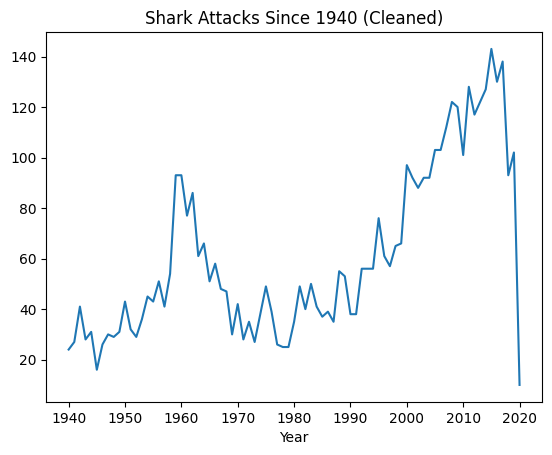

In [93]:
df_recent = df_sharks[df_sharks['Year'] >= 1940].copy()
df_recent = df_recent[df_recent['Year'] <= 2026]

yearly_counts = df_recent['Year'].value_counts().sort_index()
yearly_counts.plot(kind='line', title='Shark Attacks Since 1940 (Cleaned)')

first_decade = yearly_counts.loc[1940:1950].mean()
last_decade = yearly_counts.loc[2010:2020].mean()
print(f"Avg attacks 1940-1950: {first_decade:.2f}")
print(f"Avg attacks 2010-2020: {last_decade:.2f}")

(5)

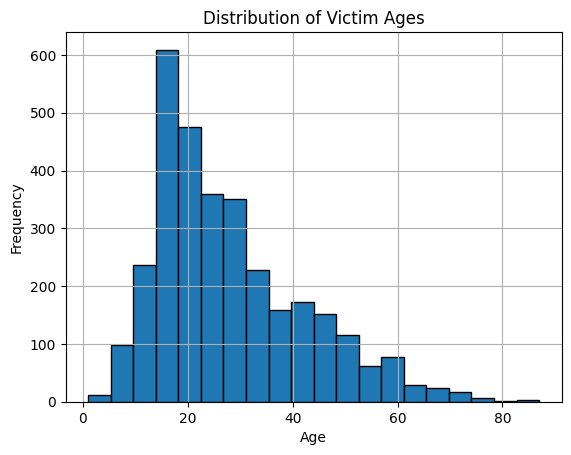

In [94]:
import matplotlib.pyplot as plt

# 1. Force Age to numeric, turning text like 'teen' into NaN
df_recent['Age_Clean'] = pd.to_numeric(df_recent['Age'], errors='coerce')

# 2. Drop the NaNs and plot the histogram
df_recent['Age_Clean'].dropna().hist(bins=20, edgecolor='black')
plt.title('Distribution of Victim Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

(6) 73.46% of attacks are unprovoked.

In [95]:
df_recent['Type'] = df_recent['Type'].replace(['Invalid', 'Sea Disaster', 'Boat', 'Boating', 'Questionable', 'Watercraft'], 'Unknown')
unprovoked_prop = (df_recent['Type'] == 'Unprovoked').mean()

print(f"Proportion of unprovoked attacks: {unprovoked_prop:.2%}")

Proportion of unprovoked attacks: 73.46%


(7)

In [96]:
df_recent['Fatal (Y/N)'] = df_recent['Fatal (Y/N)'].str.upper().str.strip()
df_recent['Fatal (Y/N)'] = df_recent['Fatal (Y/N)'].apply(lambda x: x if x in ['Y', 'N'] else 'Unknown')

(8) Looking at the cross-tabulation table, unprovoked attacks are actually more likely to be fatal than provoked ones. This makes sense because provoked attacks usually happen when humans are bothering sharks, which leads to defensive bites. Unprovoked attacks are more often predatory in nature, which usually results in more severe, fatal injuries.

In [97]:
fatality_comparison = pd.crosstab(df_recent['Type'], df_recent['Fatal (Y/N)'], normalize='index')
print("\nFatality Rate by Attack Type:")
print(fatality_comparison)


Fatality Rate by Attack Type:
Fatal (Y/N)                 N   Unknown         Y
Type                                             
Boatomg              1.000000  0.000000  0.000000
Provoked             0.959746  0.016949  0.023305
Unconfirmed          0.000000  1.000000  0.000000
Under investigation  1.000000  0.000000  0.000000
Unknown              0.391827  0.468750  0.139423
Unprovoked           0.817981  0.011307  0.170712
Unverified           1.000000  0.000000  0.000000


**Q3.** Open the "tidy_data.pdf" document available in `https://github.com/ds4e/wrangling`, which is a paper called *Tidy Data* by Hadley Wickham.

  1. Read the abstract. What is this paper about?
  2. Read the introduction. What is the "tidy data standard" intended to accomplish?
  3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."
  4. Read Section 2.2. How does Wickham define values, variables, and observations?
  5. How is "Tidy Data" defined in section 2.3?
  6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?
  7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?

Q3 Response

(1) The paper is about how to structure datasets so they are easy to analyze. It introduces a standard way of organizing data called "tidy data," which helps data scientists spend less time cleaning and more time actually modeling.

(2) The goal is to create a consistent data structure that works across various tools and functions. By having a standard format, you don't have to reinvent your cleaning process every time you get a new dataset; you just get it into "tidy" form and start your analysis.

(3) "Like families...": This means that while all tidy datasets follow the same three rules, messy datasets can be broken in infinite ways.

"For a given dataset...": This refers to how it's easy to spot rows and columns in a spreadsheet, but it's hard to define what counts as a "variable" or "observation" in a way that applies to every single dataset in the world.

(4) Values: The actual data points that sit in a cell.

Variables: These measure the same underlying attribute across all units.

Observations: These collect all the values measured on the same unit.

(5) Tidy data follows three rules: each variable forms a column, each observation forms a row, and each type of observational unit forms a table.

(6) The 5 most common problems are headers being values instead of names, multiple variables in one column, variables in both rows and columns, multiple types of units in one table, and a single unit spread across multiple tables. Table 4 is messy because the column headers are actually values, not variables. Melting is the process of turning those wide, messy columns into long, tidy rows.

(7) Table 11 is messy because it has variables as rows instead of columns. Table 12 is "molten" and tidy because it uses the "melt" process to ensure every variable has its own column and every observation has its own row.

**Q4.** This question looks at financial transfers from international actors to American universities. In particular, from which countries and giftors are the gifts coming from, and to which institutions are they going?

For this question, `.groupby([vars]).count()` and `.groupby([vars]).sum()` will be especially useful to tally the number of occurrences and sum the values of those occurrences.

1. Load the `ForeignGifts_edu.csv` dataset.
2. For `Foreign Gift Amount`, create a histogram and describe the variable. Describe your findings.
3. For `Gift Type`, create a histogram or value counts table. What proportion of the gifts are contracts, real estate, and monetary gifts?
4. What are the top 15 countries in terms of the number of gifts? What are the top 15 countries in terms of the amount given?
5. What are the top 15 institutions in terms of the total amount of money they receive? Make a histogram of the total amount received by all institutions.
6. Which giftors provide the most money, in total?

Q4 Response

(1)

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

df_gifts = pd.read_csv('data/ForeignGifts_edu.csv')

(2) The histogram for Foreign Gift Amount shows an extremely right-skewed distribution. The vast majority of the gifts are concentrated near zero, meaning most individual transfers are relatively small. However, the x-axis extends all the way to $1.0 \times 10^8$ ($100$ million dollars), which shows there are a few massive outliers or 'mega-gifts' that account for a huge portion of the total value. It’s a classic 'long tail' where the frequency of small gifts is very high, but the total financial impact is heavily influenced by a small number of very large contracts or donations.

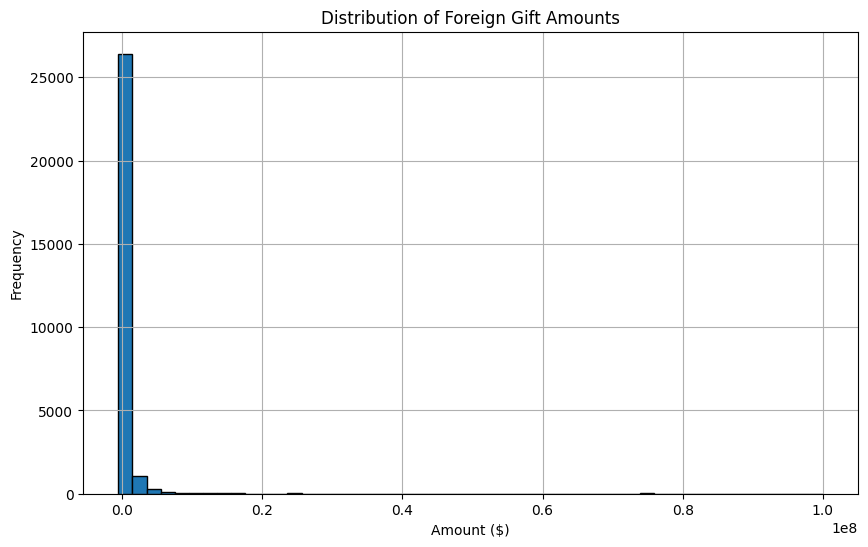

In [99]:
plt.figure(figsize=(10, 6))
df_gifts['Foreign Gift Amount'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Foreign Gift Amounts')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.show()

(3) Looking at the proportions, Contracts are actually the most common form of foreign funding, making up about 61.21% of the data. Monetary Gifts come in second at 38.75%, while Real Estate is super rare, accounting for less than 0.1% of the total transfers. This shows that the majority of foreign financial influence comes through formal service agreements or research contracts rather than just straightforward donations.

In [100]:
gift_proportions = df_gifts['Gift Type'].value_counts(normalize=True)
print("Proportions of Gift Types:")
print(gift_proportions)

Proportions of Gift Types:
Gift Type
Contract         0.612097
Monetary Gift    0.387513
Real Estate      0.000390
Name: proportion, dtype: float64


(4)

In [101]:
print(df_gifts.columns)

Index(['ID', 'OPEID', 'Institution Name', 'City', 'State',
       'Foreign Gift Received Date', 'Foreign Gift Amount', 'Gift Type',
       'Country of Giftor', 'Giftor Name'],
      dtype='object')


In [102]:
print("Top 15 Countries by Total Amount:")
print(df_gifts.groupby('Country of Giftor')['Foreign Gift Amount'].sum().nlargest(15))

Top 15 Countries by Total Amount:
Country of Giftor
QATAR                   2706240869
ENGLAND                 1464906771
CHINA                   1237952112
SAUDI ARABIA            1065205930
BERMUDA                  899593972
CANADA                   898160656
HONG KONG                887402529
JAPAN                    655954776
SWITZERLAND              619899445
INDIA                    539556490
GERMANY                  442475605
UNITED ARAB EMIRATES     431396357
FRANCE                   405839396
SINGAPORE                401157692
AUSTRALIA                248409202
Name: Foreign Gift Amount, dtype: int64


(5)

In [103]:
print("\nTop 15 Institutions by Total Amount:")
print(df_gifts.groupby('Institution Name')['Foreign Gift Amount'].sum().nlargest(15))


Top 15 Institutions by Total Amount:
Institution Name
Carnegie Mellon University                       1477922504
Cornell University                               1289937761
Harvard University                                954803610
Massachusetts Institute of Technology             859071692
Yale University                                   613441311
Texas A&M University                              521455050
Johns Hopkins University                          502409595
Northwestern University                           402316221
Georgetown University                             379950511
University of Chicago (The)                       364544338
University of Colorado Boulder                    360173159
Duke University                                   343699498
Brigham Young University                          323509863
Stanford University                               319561362
University of Texas MD Anderson Cancer Center     301527419
Name: Foreign Gift Amount, dtype: int64


(6) I found that the top sources of funding aren't usually individuals, but rather huge international corporations or foreign government agencies.

In [104]:
top_giftors = df_gifts.groupby('Giftor Name')['Foreign Gift Amount'].sum().nlargest(5)

print("Top 5 Foreign Giftors by Total Amount:")
print(top_giftors)

Top 5 Foreign Giftors by Total Amount:
Giftor Name
Qatar Foundation                       1166503744
Qatar Foundation/Qatar National Res     796197000
Qatar Foundation for Education          373945215
Anonymous                               338793629
Saudi Arabian Cultural Mission          275221475
Name: Foreign Gift Amount, dtype: int64


**Q5.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `college_completion.csv` dataset from the US Department of Education. The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `college_completion.csv` data with Pandas.
2. How many observations and variables are in the data? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see in words.
4. For `grad_100_value`, create a kernel density plot and describe table. Now condition on `control`, and produce a kernel density plot and describe tables for each type of institutional control. Which type of institution appear to have the most favorable graduation rates?
5. Make a scatterplot of `grad_100_value` by `aid_value`, and compute the covariance and correlation between the two variables. Describe what you see. Now make the same plot and statistics, but conditioning on `control`. Describe what you see. For which kinds of institutions does aid seem to vary positively with graduation rates?

Q5 Response

(2) The KDE plot shows that Public schools have the lowest graduation rates, typically clustered between 10% and 20%. In contrast, Private not-for-profit schools perform significantly better, with a wider distribution that peaks at much higher completion rates around 40%.

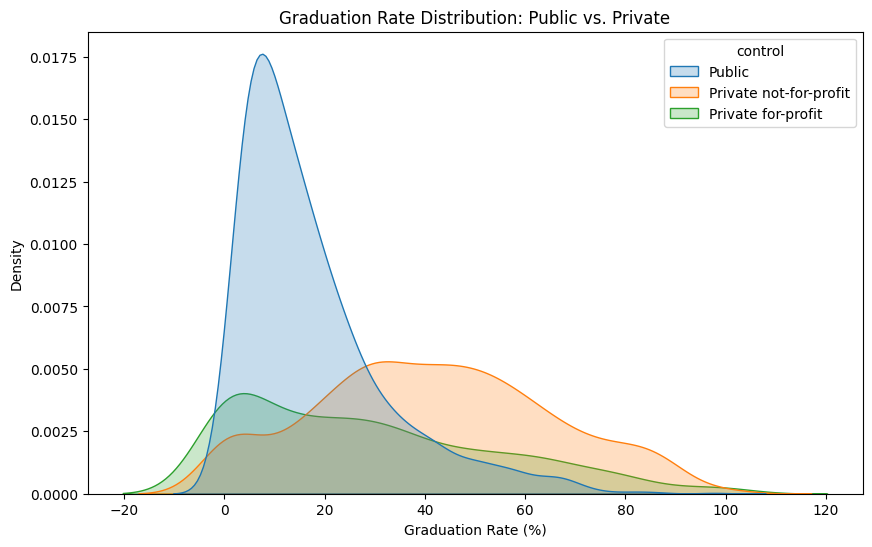

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_college = pd.read_csv('data/college_completion.csv')

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_college, x='grad_100_value', hue='control', fill=True)

plt.title('Graduation Rate Distribution: Public vs. Private')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Density')
plt.show()

(3) Most Public schools in the data are 2-year institutions, while Private not-for-profit schools are almost exclusively 4-year institutions.

In [106]:
ct = pd.crosstab(df_college['control'], df_college['level'])
print(ct)

level                   2-year  4-year
control                               
Private for-profit         465     527
Private not-for-profit      68    1180
Public                     926     632


(4) Overall, graduation rates are low and right-skewed; however, when conditioned on control, Private not-for-profit institutions clearly show the most favorable rates, with a distribution shifted much further to the right than Public or For-profit schools.

(5) While the overall relationship is weak, student aid varies most positively with graduation rates at Private not-for-profit institutions; for Public schools, the relationship is much flatter.

Overall - Cov: 88610.48, Corr: 0.58


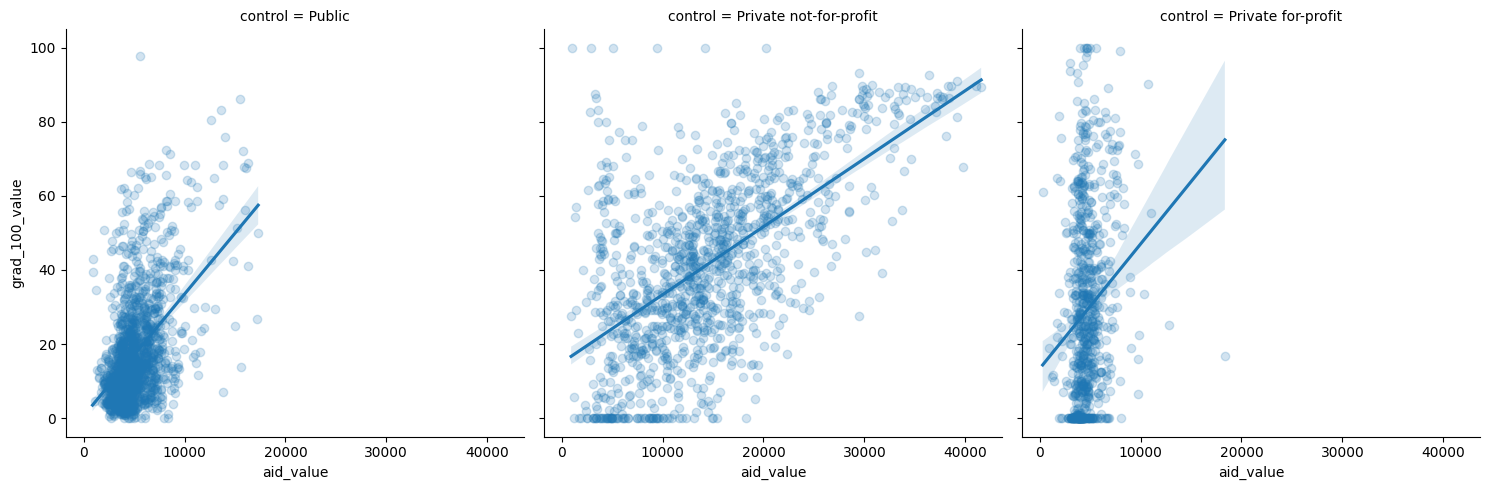

In [107]:
overall_cov = df_college['grad_100_value'].cov(df_college['aid_value'])
overall_corr = df_college['grad_100_value'].corr(df_college['aid_value'])
print(f"Overall - Cov: {overall_cov:.2f}, Corr: {overall_corr:.2f}")

sns.lmplot(data=df_college, x='aid_value', y='grad_100_value', col='control', scatter_kws={'alpha':0.2})

**Q6.** In class, we talked about how to compute the sample mean of a variable $X$,
$$
m(X) = \dfrac{1}{N} \sum_{i=1}^N x_i
$$
and sample covariance of two variables $X$ and $Y$,
$$
\text{cov}(X,Y) = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))(y_i - m(Y))).
$$
Recall, the sample variance of $X$ is
$$
s^2 = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))^2.
$$
It can be very helpful to understand some basic properties of these statistics. If you want to write your calculations on a piece of paper, take a photo, and upload that to your GitHub repo, that's probably easiest.

We're going to look at **linear transformations** of $X$, $Y = a + bX$. So we take each value of $X$, $x_i$, and transform it as $y_i = a + b x_i$.

1. Show that $m(a + bX) = a+b \times m(X)$.
2. Show that $ \text{cov}(X,X) = s^2$.
3. Show that $\text{cov}(X,a+bY) = b \times \text{cov}(X,Y)$
4. Show that $\text{cov}(a+bX,a+bY) = b^2 \text{cov}(X,Y) $. Notice, this also means that $\text{cov}(bX, bX) = b^2 s^2$.
5. Suppose $b>0$ and let the median of $X$ be $\text{med}(X)$. Is it true that the median of $a+bX$ is equal to $a + b \times \text{med}(X)$? Is the IQR of $a + bX$ equal to $a + b \times \text{IQR}(X)$?
6. Show by example that the means of $X^2$ and $\sqrt{X}$ are generally not $(m(X))^2$ and $\sqrt{m(X)}$. So, the results we derived above really depend on the linearity of the transformation $Y = a + bX$, and transformations like $Y = X^2$ or $Y = \sqrt{X}$ will not behave in a similar way.

Q6 Response

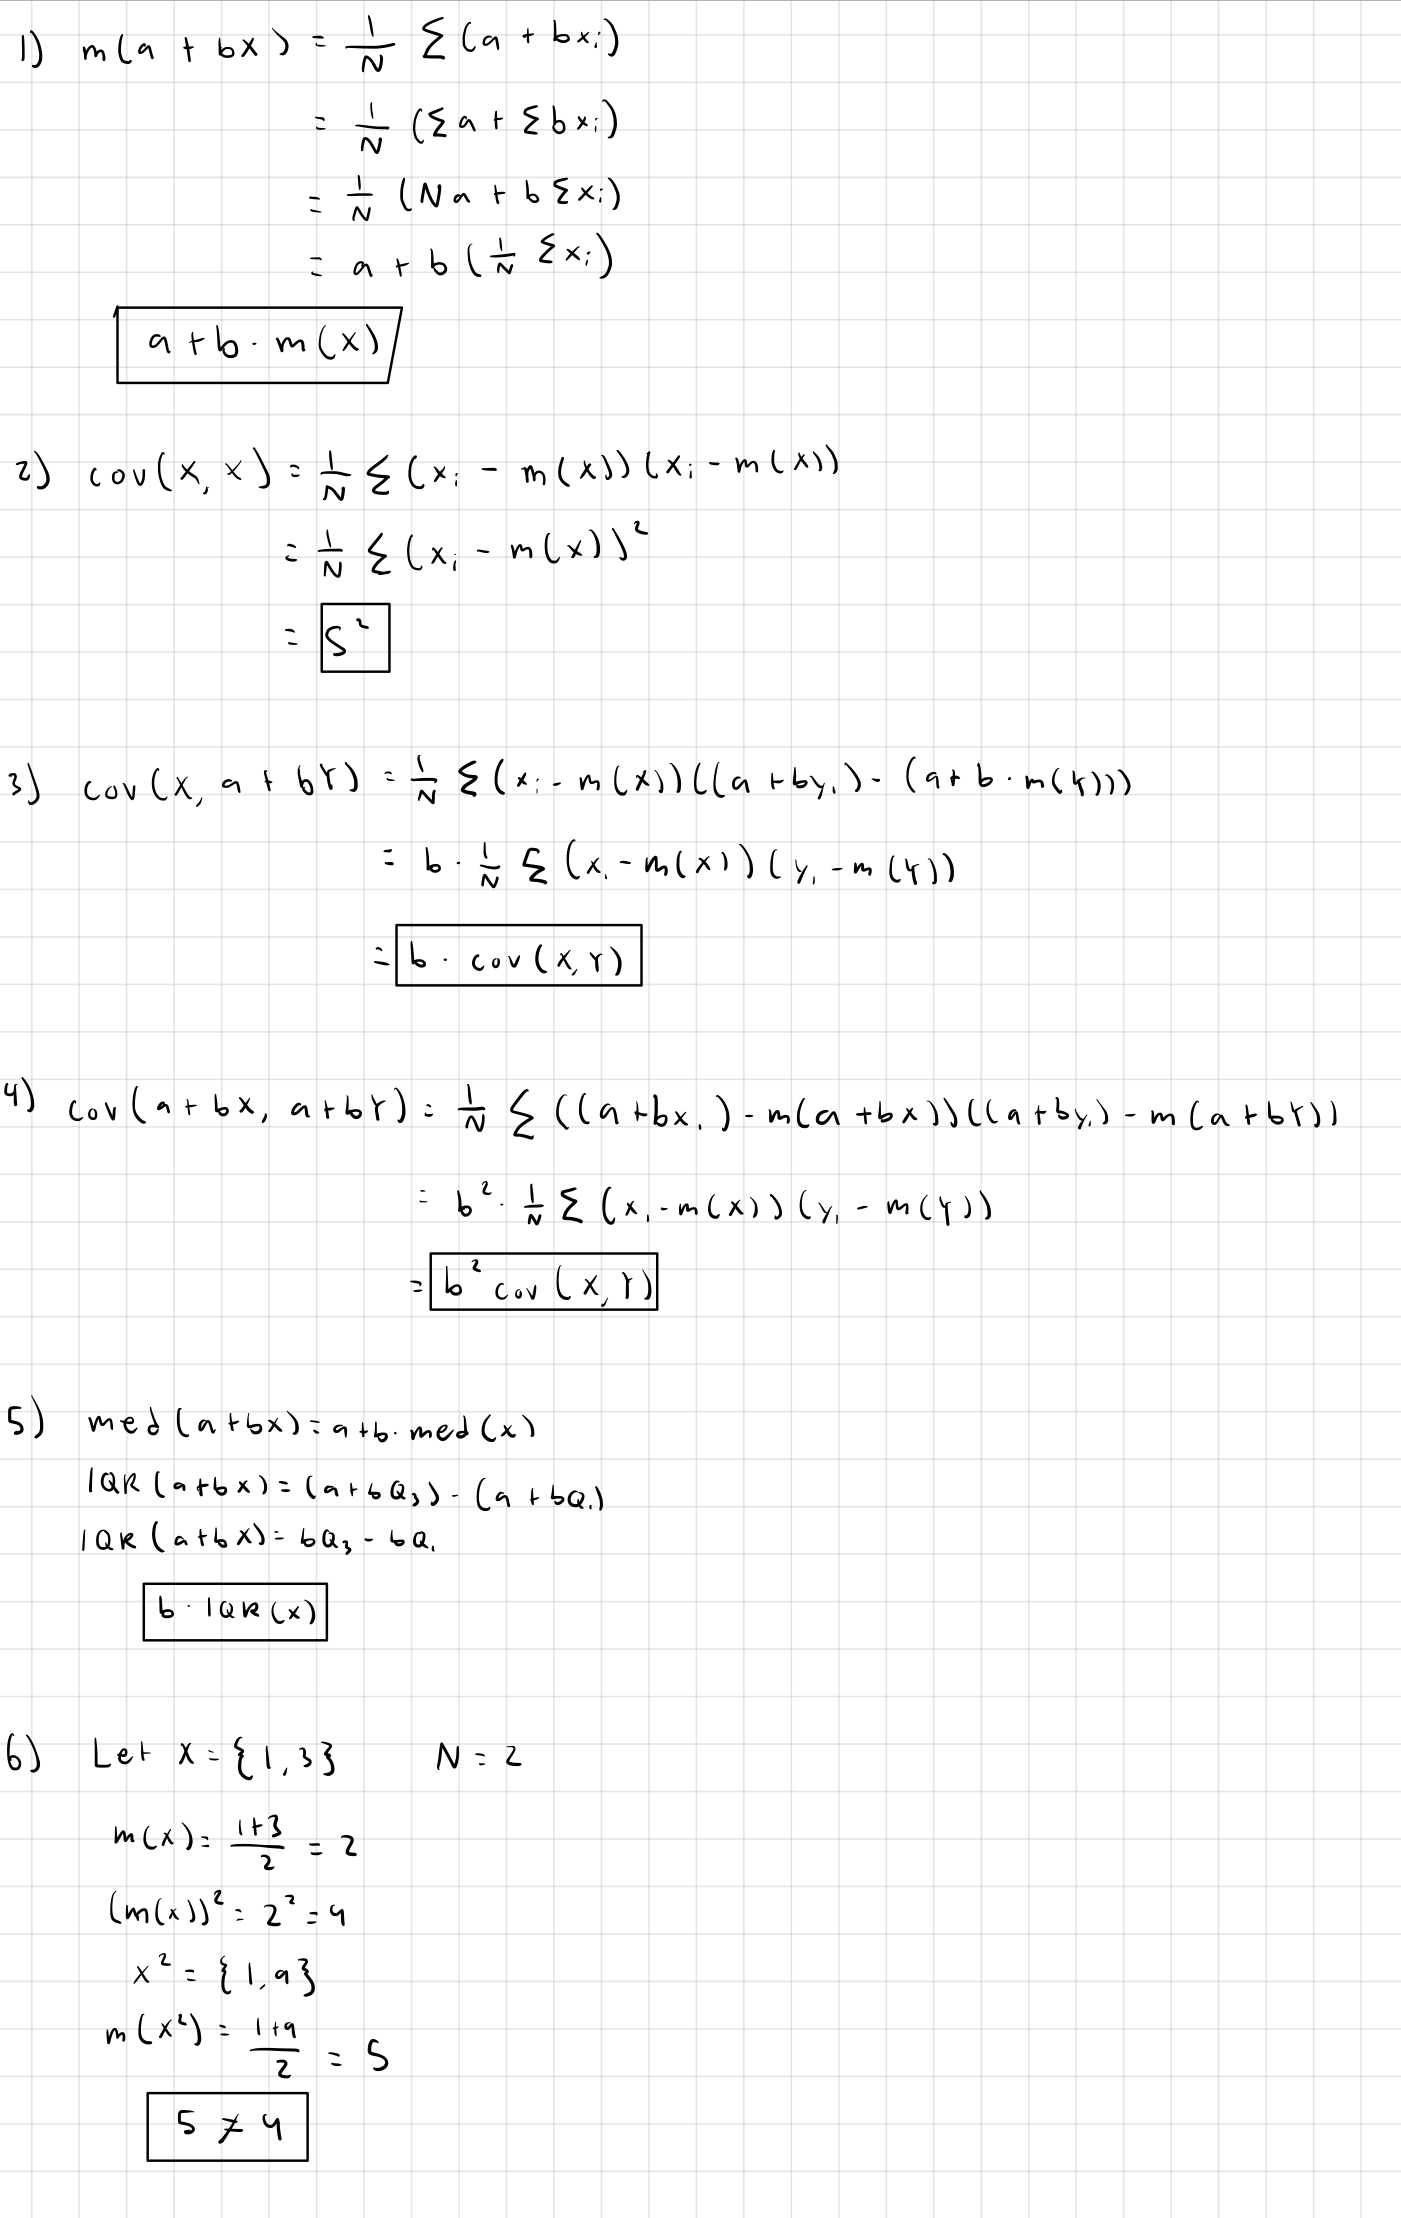

**Q7.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `ames_prices.csv` dataset. The "relevant" variables for this question are:
  - `price` - Sale price value of the house
  - `Bldg.Type` - Building type of the house (single family home, end-of-unit townhome, duplex, interior townhome, two-family conversion)

1. Load the `college_completion.csv` data with Pandas.
2. Make a kernel density plot of price and compute a describe table. Now, make a kernel density plot of price conditional on building type, and use `.groupby()` to make a describe type for each type of building. Which building types are the most expensive, on average? Which have the highest variance in transaction prices?
3. Make an ECDF plot of price, and compute the sample minimum, .25 quantile, median, .75 quantile, and sample maximum (i.e. a 5-number summary).
4. Make a boxplot of price. Are there outliers? Make a boxplot of price conditional on building type. What patterns do you see?
5. Make a dummy variable indicating that an observation is an outlier.
6. Winsorize the price variable, and compute a new kernel density plot and describe table. How do the results change?

Q7 Response

(1)

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_ames = pd.read_csv('data/ames_prices.csv')
print(df_ames.head())
print(df_ames.shape)

   Order        PID  area   price  MS.SubClass MS.Zoning  Lot.Frontage  \
0      1  526301100  1656  215000           20        RL         141.0   
1      2  526350040   896  105000           20        RH          80.0   
2      3  526351010  1329  172000           20        RL          81.0   
3      4  526353030  2110  244000           20        RL          93.0   
4      5  527105010  1629  189900           60        RL          74.0   

   Lot.Area Street Alley  ... Screen.Porch Pool.Area Pool.QC  Fence  \
0     31770   Pave   NaN  ...            0         0     NaN    NaN   
1     11622   Pave   NaN  ...          120         0     NaN  MnPrv   
2     14267   Pave   NaN  ...            0         0     NaN    NaN   
3     11160   Pave   NaN  ...            0         0     NaN    NaN   
4     13830   Pave   NaN  ...            0         0     NaN  MnPrv   

  Misc.Feature Misc.Val Mo.Sold Yr.Sold Sale.Type Sale.Condition  
0          NaN        0       5    2010       WD          Nor

(2) On average, TwnhsE and 1Fam homes are the most expensive, with mean prices around $\$192,311$ and $\$184,812$ respectively. 1-Family homes have the highest variance in transaction prices, with a standard deviation of $\$82,821$ and a price range stretching from $\$12,789$ to $\$755,000$.

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: price, dtype: float64


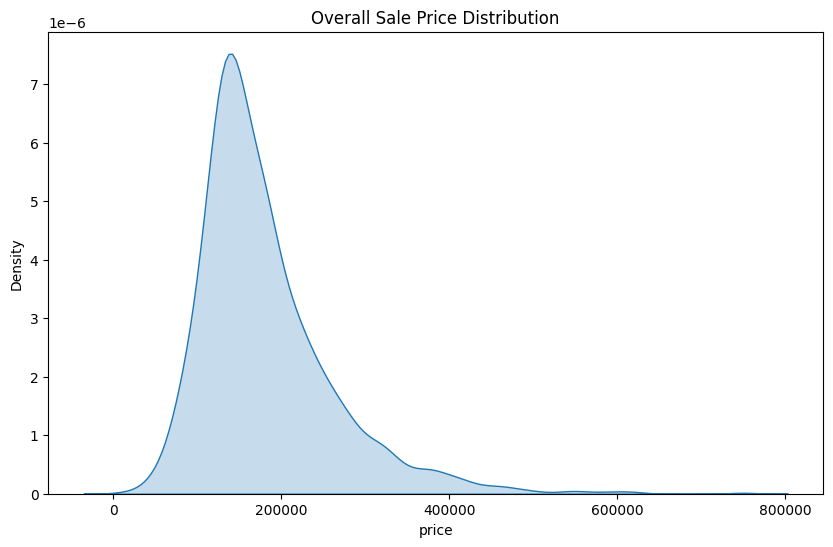

            count           mean           std      min       25%       50%  \
Bldg.Type                                                                     
1Fam       2425.0  184812.041237  82821.802329  12789.0  130000.0  165000.0   
2fmCon       62.0  125581.709677  31089.239840  55000.0  106562.5  122250.0   
Duplex      109.0  139808.935780  39498.973534  61500.0  118858.0  136905.0   
Twnhs       101.0  135934.059406  41938.931130  73000.0  100500.0  130000.0   
TwnhsE      233.0  192311.914163  66191.738021  71000.0  145000.0  180000.0   

                75%       max  
Bldg.Type                      
1Fam       220000.0  755000.0  
2fmCon     140000.0  228950.0  
Duplex     153337.0  269500.0  
Twnhs      170000.0  280750.0  
TwnhsE     222000.0  392500.0  


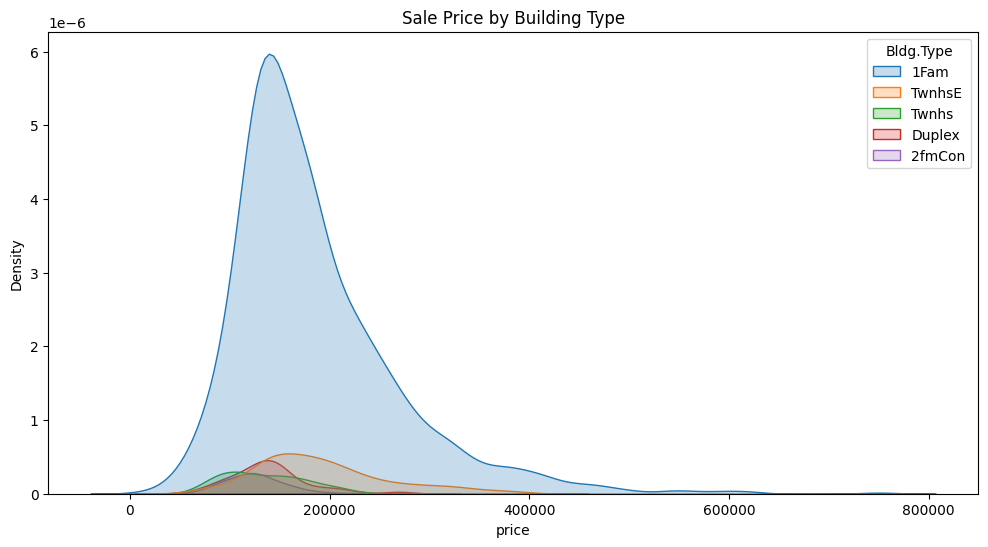

In [109]:
print(df_ames['price'].describe())

plt.figure(figsize=(10, 6))
sns.kdeplot(df_ames['price'], fill=True)
plt.title('Overall Sale Price Distribution')
plt.show()

print(df_ames.groupby('Bldg.Type')['price'].describe())

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_ames, x='price', hue='Bldg.Type', fill=True)
plt.title('Sale Price by Building Type')
plt.show()

(3)

count      2930.000000
mean     176866.205119
std       67394.809835
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      335000.000000
Name: price_winsor, dtype: float64


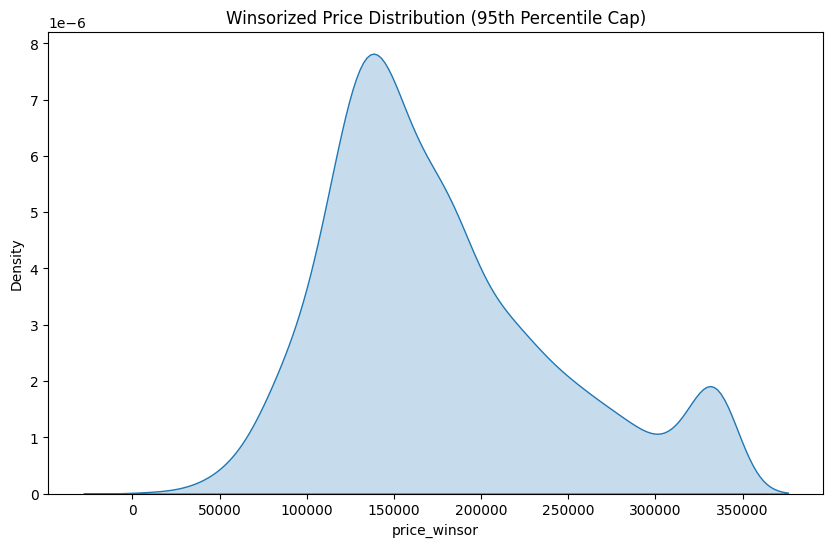

In [110]:
p95 = df_ames['price'].quantile(0.95)

df_ames['price_winsor'] = df_ames['price'].clip(upper=p95)

print(df_ames['price_winsor'].describe())

plt.figure(figsize=(10, 6))
sns.kdeplot(df_ames['price_winsor'], fill=True)
plt.title('Winsorized Price Distribution (95th Percentile Cap)')
plt.show()

(4) Yes, the overall boxplot shows many outliers represented by individual points extending far to the right of the maximum whisker, indicating several homes are priced significantly higher than the rest of the distribution. 1Fam homes have the most extreme outliers and the widest price range, while Twnhs units are much more tightly clustered with fewer extreme price variations.

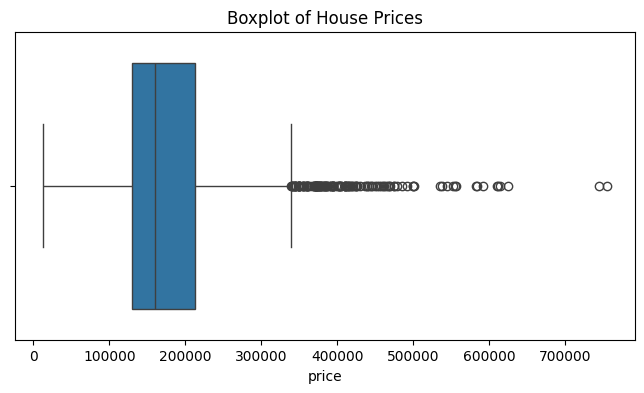

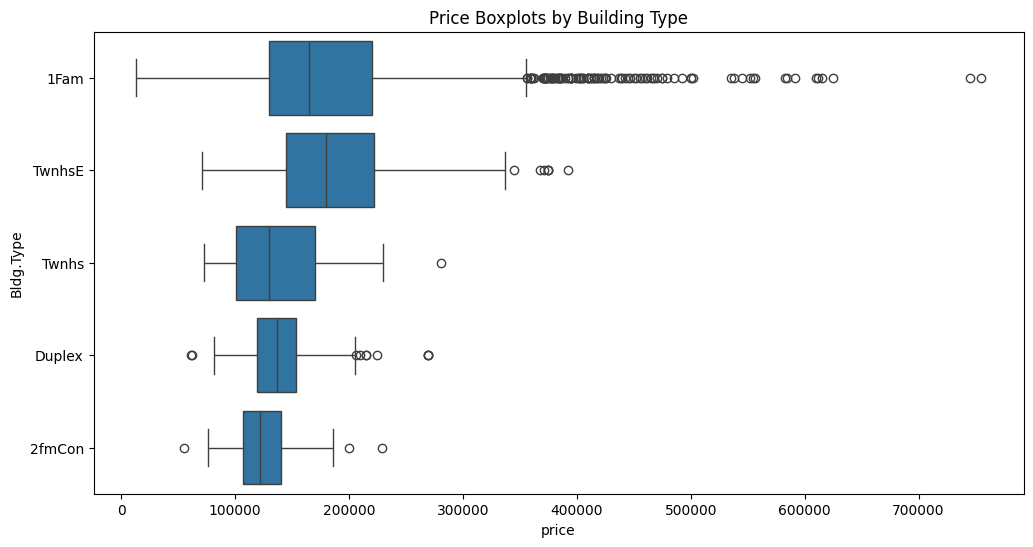

In [111]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_ames['price'])
plt.title('Boxplot of House Prices')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_ames, x='price', y='Bldg.Type')
plt.title('Price Boxplots by Building Type')
plt.show()

(5)

In [112]:
Q1 = df_ames['price'].quantile(0.25)
Q3 = df_ames['price'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

df_ames['is_outlier'] = (df_ames['price'] > upper_bound).astype(int)

print(df_ames['is_outlier'].value_counts())
print(f"Outlier Threshold: {upper_bound}")

is_outlier
0    2793
1     137
Name: count, dtype: int64
Outlier Threshold: 339500.0


(6) The max price dropped from 755,000 to 335,000, and the standard deviation dropped from 79,886 to 67,394. This shows that Winsorization makes the data less noisy by limiting the impact of those extreme luxury home prices.

count      2930.000000
mean     176866.205119
std       67394.809835
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      335000.000000
Name: price_winsor, dtype: float64


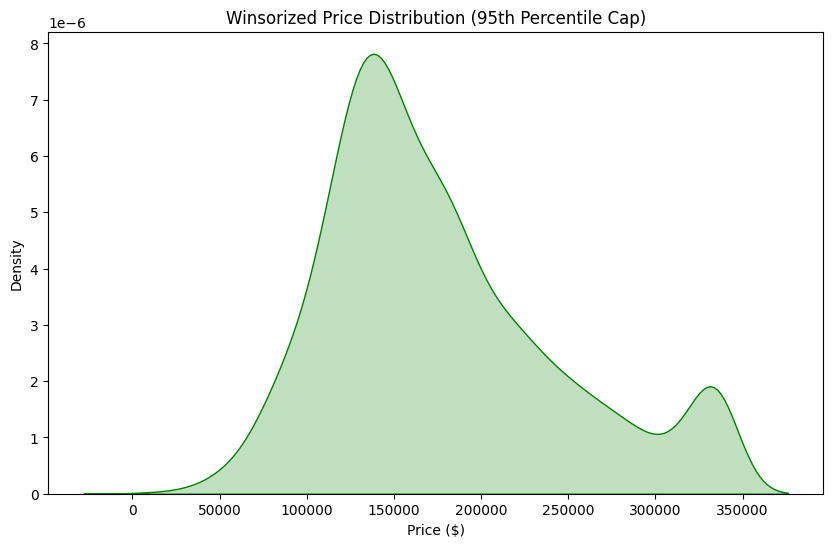

In [113]:
p95 = df_ames['price'].quantile(0.95)

df_ames['price_winsor'] = df_ames['price'].clip(upper=p95)

print(df_ames['price_winsor'].describe())

plt.figure(figsize=(10, 6))
sns.kdeplot(df_ames['price_winsor'], fill=True, color='green')
plt.title('Winsorized Price Distribution (95th Percentile Cap)')
plt.xlabel('Price ($)')
plt.show()